In [30]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from six.moves import zip
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
print(__doc__)


def plot_gallery(images, titles, h, w, n_row = 7, n_col=7):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

Automatically created module for IPython interactive environment


In [31]:

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [109]:

###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
print("-------------------------")
print("Size of training set: ", X_train.shape[0])
print("Size of testing set: ", X_test.shape[0])

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))



-------------------------
Size of training set:  966
Size of testing set:  322
Extracting the top 100 eigenfaces from 966 faces
done in 0.089s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


In [110]:
################################################################################
randomforest_clf = RandomForestClassifier(n_estimators=80,max_depth = 10)
"""
class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
"""
decisiontree_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2,random_state=0)
"""
class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, class_weight=None, presort=False)
"""
extratree_clf = ExtraTreesClassifier(n_estimators=20, max_depth=None,min_samples_split=2, random_state=0)
"""
class sklearn.ensemble.ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
"""
bagging_clf = BaggingClassifier(KNeighborsClassifier(),n_estimators=20,max_samples=0.5, max_features=0.5)
"""
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
"""

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
voting_clf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1,1,5])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
voting_clf = voting_clf.fit(X_train_pca, y_train)

boosting_clf = GradientBoostingClassifier(n_estimators=350, learning_rate=0.8, max_depth=3, random_state=0)
"""
class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
"""
randomforest_clf=randomforest_clf.fit(X_train_pca, y_train)
decisiontree_clf=decisiontree_clf.fit(X_train_pca, y_train)
extratree_clf = extratree_clf.fit(X_train_pca, y_train)
bagging_clf = bagging_clf.fit(X_train_pca, y_train)
boosting_clf =boosting_clf.fit(X_train_pca, y_train)
#################################################################################


--------The results of RandomForestClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.84      0.52      0.64        60
  Donald Rumsfeld       0.67      0.15      0.24        27
    George W Bush       0.55      0.99      0.71       146
Gerhard Schroeder       0.83      0.20      0.32        25
      Hugo Chavez       1.00      0.27      0.42        15
       Tony Blair       0.86      0.17      0.28        36

         accuracy                           0.60       322
        macro avg       0.68      0.33      0.37       322
     weighted avg       0.67      0.60      0.54       322

[[  0   0   0  13   0   0   0]
 [  0  31   0  28   0   0   1]
 [  0   1   4  21   1   0   0]
 [  0   0   2 144   0   0   0]
 [  0   1   0  19   5   0   0]
 [  0   1   0  10   0   4   0]
 [  0   3   0  27   0   0   6]]


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


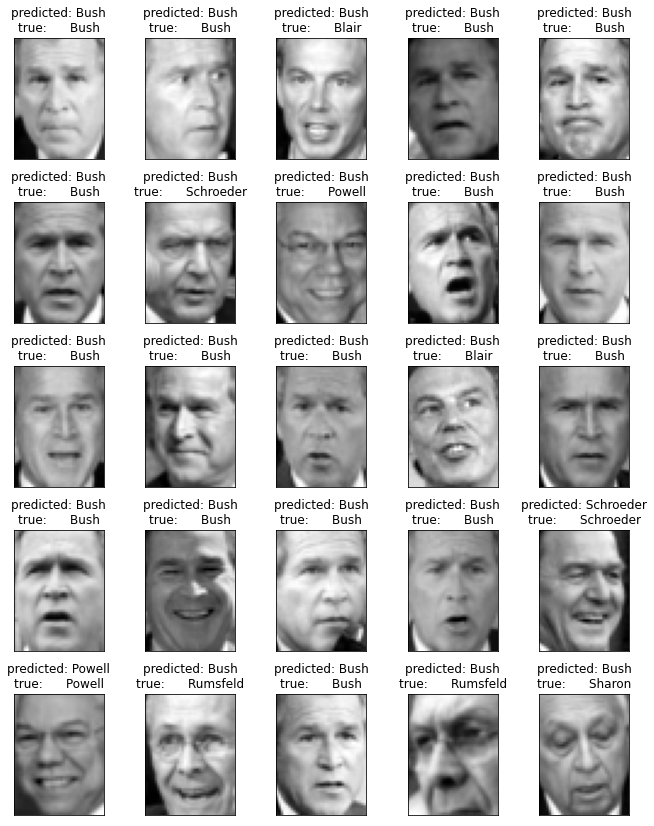

In [111]:
y_randomforest_pred = randomforest_clf.predict(X_test_pca)
print("""--------The results of RandomForestClassifier----------------""")
print(classification_report(y_test, y_randomforest_pred, target_names=target_names))
print(confusion_matrix(y_test, y_randomforest_pred, labels=range(n_classes)))

prediction_titles_RF = [title(y_randomforest_pred, y_test, target_names, i) for i in range(y_randomforest_pred.shape[0])]

plot_gallery(X_test, prediction_titles_RF, h, w)


--------The results of DecisionTreeClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.06      0.08      0.06        13
     Colin Powell       0.28      0.37      0.32        60
  Donald Rumsfeld       0.15      0.19      0.17        27
    George W Bush       0.63      0.51      0.57       146
Gerhard Schroeder       0.29      0.36      0.32        25
      Hugo Chavez       0.10      0.13      0.11        15
       Tony Blair       0.18      0.11      0.14        36

         accuracy                           0.37       322
        macro avg       0.24      0.25      0.24       322
     weighted avg       0.40      0.37      0.38       322

[[ 1  5  2  3  1  1  0]
 [ 5 22  9 14  1  5  4]
 [ 2  9  5  5  2  1  3]
 [ 8 26 14 75  9  7  7]
 [ 1  4  1  6  9  2  2]
 [ 1  3  1  4  2  2  2]
 [ 0 10  1 12  7  2  4]]


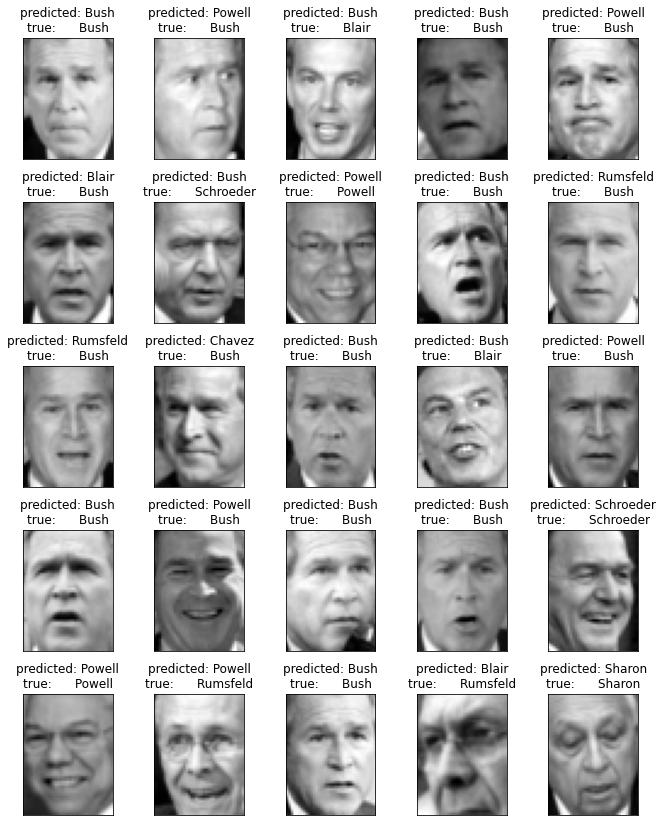

In [112]:
y_decisiontree_pred = decisiontree_clf.predict(X_test_pca)
print("""--------The results of DecisionTreeClassifier----------------""")
print(classification_report(y_test, y_decisiontree_pred, target_names=target_names))
print(confusion_matrix(y_test, y_decisiontree_pred, labels=range(n_classes)))

prediction_titles_DT = [title(y_decisiontree_pred, y_test, target_names, i) for i in range(y_decisiontree_pred.shape[0])]

plot_gallery(X_test, prediction_titles_DT, h, w)

--------The results of ExtraTreesClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.52      0.63      0.57        60
  Donald Rumsfeld       0.64      0.33      0.44        27
    George W Bush       0.59      0.88      0.71       146
Gerhard Schroeder       0.60      0.12      0.20        25
      Hugo Chavez       1.00      0.07      0.12        15
       Tony Blair       0.50      0.14      0.22        36

         accuracy                           0.57       322
        macro avg       0.55      0.31      0.32       322
     weighted avg       0.57      0.57      0.51       322

[[  0   2   1  10   0   0   0]
 [  0  38   0  21   0   0   1]
 [  0   3   9  14   1   0   0]
 [  1  12   2 129   0   0   2]
 [  0   9   2   9   3   0   2]
 [  0   3   0  10   1   1   0]
 [  0   6   0  25   0   0   5]]


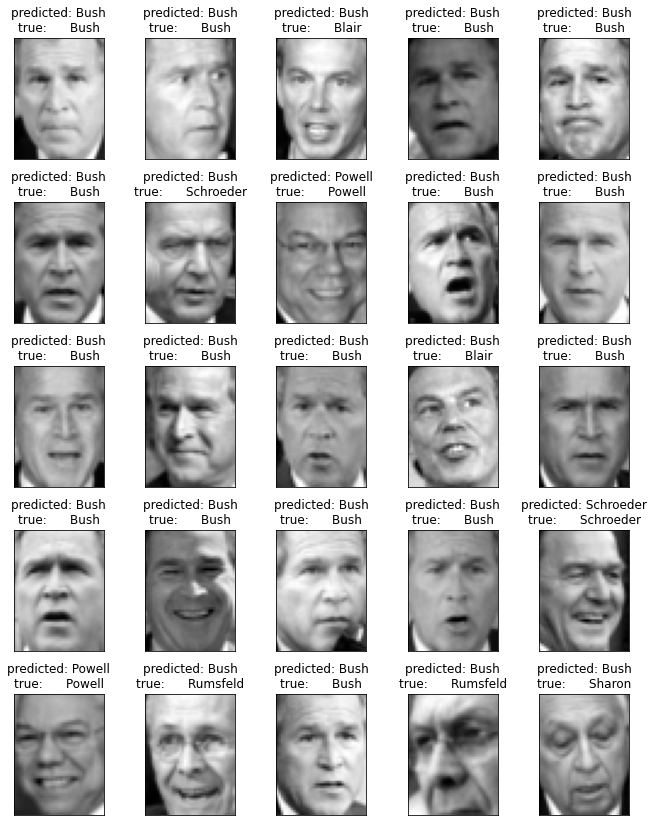

In [113]:
y_extratree_pred = extratree_clf.predict(X_test_pca)
print("""--------The results of ExtraTreesClassifier----------------""")
print(classification_report(y_test, y_extratree_pred, target_names=target_names))
print(confusion_matrix(y_test, y_extratree_pred, labels=range(n_classes)))

prediction_titles_ET = [title(y_extratree_pred, y_test, target_names, i) for i in range(y_extratree_pred.shape[0])]

plot_gallery(X_test, prediction_titles_ET, h, w)


--------The results of BaggingClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.15      0.27        13
     Colin Powell       0.96      0.43      0.60        60
  Donald Rumsfeld       1.00      0.15      0.26        27
    George W Bush       0.53      0.99      0.69       146
Gerhard Schroeder       0.80      0.16      0.27        25
      Hugo Chavez       1.00      0.13      0.24        15
       Tony Blair       0.90      0.25      0.39        36

         accuracy                           0.60       322
        macro avg       0.89      0.32      0.39       322
     weighted avg       0.75      0.60      0.53       322

[[  2   0   0  11   0   0   0]
 [  0  26   0  33   0   0   1]
 [  0   0   4  23   0   0   0]
 [  0   1   0 145   0   0   0]
 [  0   0   0  21   4   0   0]
 [  0   0   0  12   1   2   0]
 [  0   0   0  27   0   0   9]]


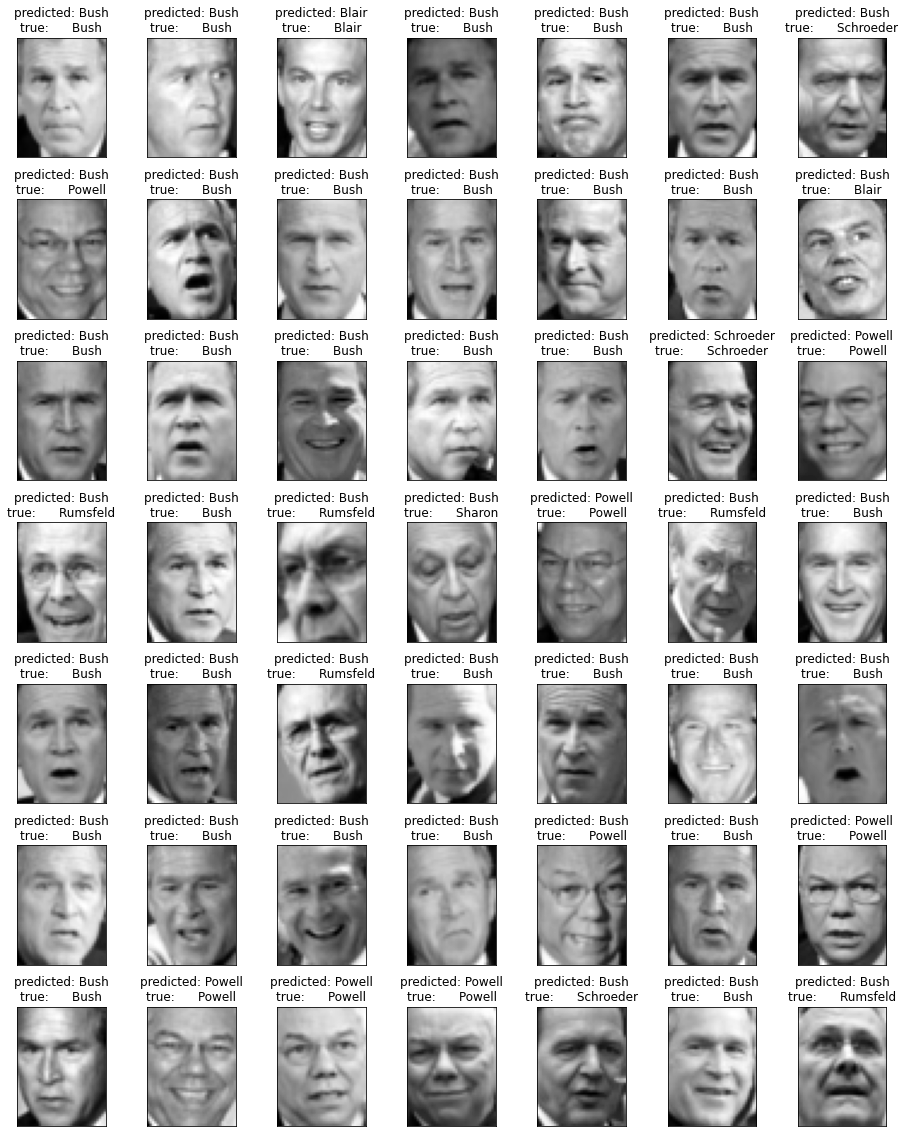

In [118]:
y_bagging_pred = bagging_clf.predict(X_test_pca)
print("""--------The results of BaggingClassifier----------------""")
print(classification_report(y_test, y_bagging_pred, target_names=target_names))
print(confusion_matrix(y_test, y_bagging_pred, labels=range(n_classes)))

prediction_titles_BG = [title(y_bagging_pred, y_test, target_names, i) for i in range(y_bagging_pred.shape[0])]

plot_gallery(X_test, prediction_titles_BG, h, w)


--------The results of VotingClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.89      0.90      0.89        60
  Donald Rumsfeld       0.76      0.70      0.73        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.83      0.67      0.74        15
       Tony Blair       0.88      0.81      0.84        36

         accuracy                           0.87       322
        macro avg       0.84      0.79      0.81       322
     weighted avg       0.87      0.87      0.87       322

[[  9   0   3   1   0   0   0]
 [  1  54   0   3   1   1   0]
 [  1   1  19   6   0   0   0]
 [  0   3   2 139   0   1   1]
 [  0   0   0   3  20   0   2]
 [  0   3   0   1   0  10   1]
 [  0   0   1   3   3   0  29]]


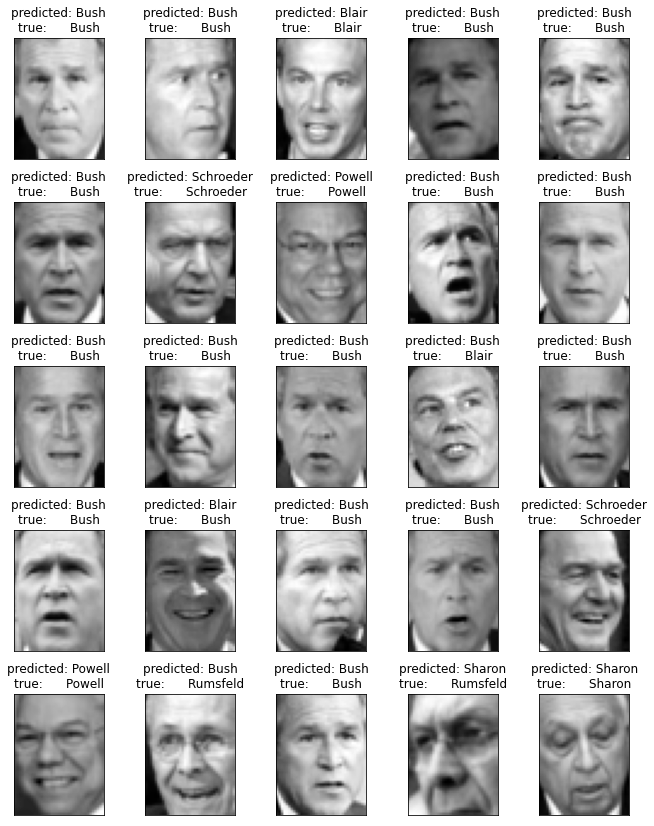

In [115]:
y_voting_pred = voting_clf.predict(X_test_pca)
print("""--------The results of VotingClassifier----------------""")
print(classification_report(y_test, y_voting_pred, target_names=target_names))
print(confusion_matrix(y_test, y_voting_pred, labels=range(n_classes)))


prediction_titles_VT = [title(y_voting_pred, y_test, target_names, i) for i in range(y_voting_pred.shape[0])]

plot_gallery(X_test, prediction_titles_VT, h, w)


--------The results of GradientBoostingClassifier----------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.27      0.31      0.29        13
     Colin Powell       0.82      0.77      0.79        60
  Donald Rumsfeld       0.54      0.52      0.53        27
    George W Bush       0.81      0.86      0.83       146
Gerhard Schroeder       0.67      0.48      0.56        25
      Hugo Chavez       0.60      0.60      0.60        15
       Tony Blair       0.62      0.64      0.63        36

         accuracy                           0.72       322
        macro avg       0.62      0.60      0.60       322
     weighted avg       0.72      0.72      0.72       322

[[  4   2   4   2   0   0   1]
 [  2  46   1   8   0   1   2]
 [  2   2  14   9   0   0   0]
 [  4   2   5 125   3   2   5]
 [  0   2   1   2  12   2   6]
 [  1   1   1   3   0   9   0]
 [  2   1   0   6   3   1  23]]


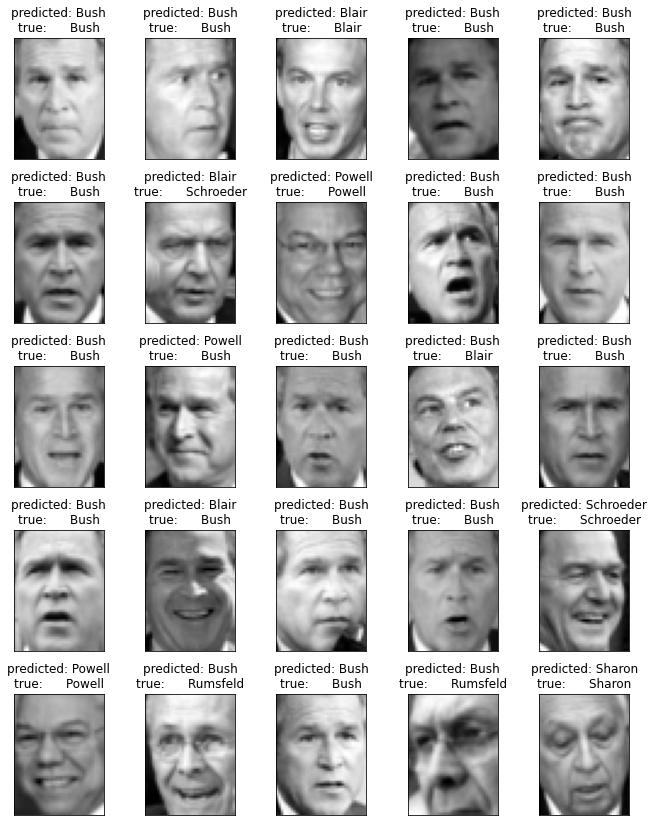

In [116]:
y_boosting_pred = boosting_clf.predict(X_test_pca)
print("""--------The results of GradientBoostingClassifier----------------""")
print(classification_report(y_test, y_boosting_pred, target_names=target_names))
print(confusion_matrix(y_test, y_boosting_pred, labels=range(n_classes)))

prediction_titles_BS = [title(y_boosting_pred, y_test, target_names, i) for i in range(y_boosting_pred.shape[0])]

plot_gallery(X_test, prediction_titles_BS, h, w)